In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2023-03-02 11:00
# @Author  : zhangbowen


import torch
from model.lstm import LSTM
from dataset import get_data
from utils.hyperparameters import BATCH_SIZE, NAME_CLASSES, EPOCH, NAME_NET
import matplotlib.pyplot as plt
from matplotlib import cm
import json
from PIL import Image
import cv2
import numpy as np
from utils.openpose_net import OpenPoseNet
from utils.decode_pose import decode_pose
import warnings
warnings.filterwarnings('ignore')

In [2]:
########## device ##########
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if str(device) == 'cuda:0':
    print('total gpu(s): {}'.format(torch.cuda.device_count()))
    print('gpu name(s): {}'.format(torch.cuda.get_device_name()))
    print('gpu spec(s): {} GB'.format(torch.cuda.get_device_properties(0).total_memory / 1024 / 1024 / 1024))
print('device: {}'.format(device))
print('====================')

total gpu(s): 1
gpu name(s): NVIDIA GeForce RTX 3050 Ti Laptop GPU
gpu spec(s): 3.99951171875 GB
device: cuda:0


### step 1: image -> keypoint coordinate (pose estimation)

In [3]:
########## COCO keypoints format ##########
# order of openpose: 18 keypoints (include 'neck')
keypoint_18 = {
    0: 'nose', 1: 'neck', 2: 'right_shoulder', 3: 'right_elbow', 4: 'right_wrist',
    5: 'left_shoulder', 6: 'left_elbow', 7: 'left_wrist', 8: 'right_hip', 9: 'right_knee', 
    10: 'right_ankle', 11: 'left_hip', 12: 'left_knee', 13: 'left_ankle', 14: 'right_eye', 
    15: 'left_eye', 16: 'right_ear', 17: 'left_ear'
}

# order of AIST & custom dataset: 17 keypoints (not include 'neck')
keypoint_17 = {
    0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear', 
    5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow', 9: 'left_wrist', 
    10: 'right_wrist', 11: 'left_hip', 12: 'right_hip', 13: 'left_knee', 14: 'right_knee', 
    15: 'left_ankle', 16: 'right_ankle'
}

# keypoint_17 = {
#     'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4, 
#     'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8, 'left_wrist': 9, 
#     'right_wrist': 10, 'left_hip': 11, 'right_hip': 12, 'left_knee': 13, 'right_knee': 14, 
#     'left_ankle': 15, 'right_ankle': 16
# }

In [4]:
########## training dataset (17 keypoints for LSTM) ##########
keypoint_17_columns = [
    'x_nose', 'y_nose', # features
    'x_left_eye', 'y_left_eye', 
    'x_right_eye', 'y_right_eye', 
    'x_left_ear', 'y_left_ear', 
    'x_right_ear', 'y_right_ear', 
    'x_left_shoulder', 'y_left_shoulder', 
    'x_right_shoulder', 'y_right_shoulder', 
    'x_left_elbow', 'y_left_elbow', 
    'x_right_elbow', 'y_right_elbow', 
    'x_left_wrist', 'y_left_wrist', 
    'x_right_wrist', 'y_right_wrist', 
    'x_left_hip', 'y_left_hip', 
    'x_right_hip', 'y_right_hip', 
    'x_left_knee', 'y_left_knee', 
    'x_right_knee', 'y_right_knee', 
    'x_left_ankle', 'y_left_ankle', 
    'x_right_ankle', 'y_right_ankle',
    'if_dance' # label
]

In [5]:
########## network ##########
net_pose = OpenPoseNet()

########## load weights ##########
weights_pose_path = './weights/pose_model_scratch.pth'
net_pose_weights = torch.load(weights_pose_path, map_location=device)

# because, pre-trained model (layer names) is different from our model (layer names)
# so, copy pre-trained model (layer names) to our model (layer names: net.state_dict().keys)
keys = list(net_pose_weights.keys())
weights_load = {}
for i in range(len(keys)):
    weights_load[list(net_pose.state_dict().keys())[i]] = net_pose_weights[list(keys)[i]]
state = net_pose.state_dict()
state.update(weights_load)
flag = net_pose.load_state_dict(state)
print(flag)
print(weights_pose_path + ': loaded!')
print('====================')

<All keys matched successfully>
./weights/pose_model_scratch.pth: loaded!


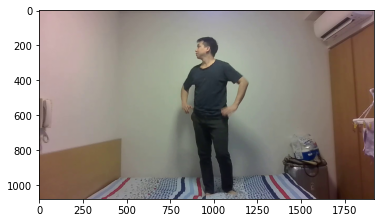

In [20]:
# read original image
test_image = './custom_no_dance/image/60.jpg'
oriImg = cv2.imread(test_image) # BGR
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB) # BGR -> RGB
plt.imshow(oriImg)
plt.show()

# resize
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# pre-processing
img = img.astype(np.float32) / 255.

# standardization
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy() # RGB
for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32) # (H, W, C) -> (C, H, W)
img = torch.from_numpy(img) # ndarray -> tensor
x = img.unsqueeze(0) # (C, H, W) -> (N, C, H, W):(1, 3, 368, 368)
print('====================')

In [21]:
########## inference ##########
# output heatmaps & PAFs
net_pose.eval()
predicted_outputs, _ = net_pose(x) # _ is saved_for_loss

# tensor -> ndarray
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

# resize to original
pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
print('====================')

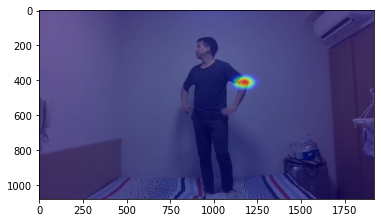

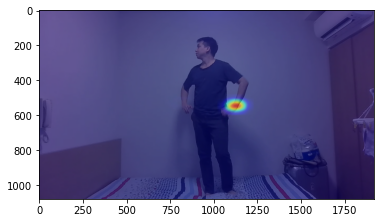

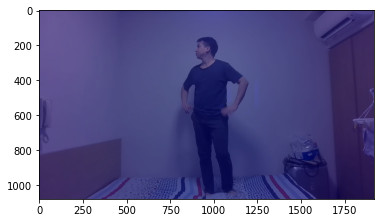

In [22]:
########## visualize heatmap of 左肘, heatmap of 左手首, PAFs of 左肘 & 左手首 ##########
## 左肘
heat_map = heatmaps[:, :, 6] # 6: 左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
# show original image + heatmap
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

## 左手首
heat_map = heatmaps[:, :, 7] # 7: 左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
# show original image + heatmap
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# PAFs of 左肘 & 左手首
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))
# show original image + PAFs
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()
print('====================')

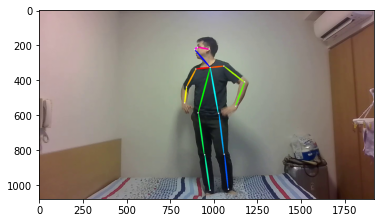

In [23]:
########## visualize link results(calculated by original image, heatmaps, PAFs) ##########
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

# show original image + result
plt.imshow(result_img)
plt.show()
print('====================')

In [24]:
########## decode to keypoint info ##########
original_img, result_img, joint_list, person_to_joint_assoc = decode_pose(oriImg, heatmaps, pafs)

########## get all keypoint_18_format results except 'neck' ##########
result_keypoint_17 = []
# joint_list(e.g. 18, 5): (row: number of joints), (column: x, y, score, id, joint type)
for i in range(len(joint_list)):
    # delet 'neck'
    if keypoint_18[joint_list[i][-1]] != 'neck': 
        print('x:{}  ||  y:{}  ||  score:{:.2f}  ||  joint:{} ({})'.format(
            joint_list[i][0], joint_list[i][1], joint_list[i][2], int(joint_list[i][-1]), keypoint_18[joint_list[i][-1]]
        ))
        # x, y, score, joint name
        result_keypoint_17.append([ joint_list[i][0], joint_list[i][1], joint_list[i][2], keypoint_18[joint_list[i][-1]] ]) 

result_keypoint_17 = np.array(result_keypoint_17)
print('====================')

x:893.0  ||  y:225.0  ||  score:0.89  ||  joint:0 (nose)
x:898.0  ||  y:337.0  ||  score:0.92  ||  joint:2 (right_shoulder)
x:845.0  ||  y:440.0  ||  score:0.89  ||  joint:3 (right_elbow)
x:834.0  ||  y:530.0  ||  score:0.89  ||  joint:4 (right_wrist)
x:1059.0  ||  y:320.0  ||  score:0.88  ||  joint:5 (left_shoulder)
x:1178.0  ||  y:411.0  ||  score:0.96  ||  joint:6 (left_elbow)
x:1127.0  ||  y:548.0  ||  score:0.94  ||  joint:7 (left_wrist)
x:911.0  ||  y:587.0  ||  score:0.66  ||  joint:8 (right_hip)
x:949.0  ||  y:827.0  ||  score:0.77  ||  joint:9 (right_knee)
x:980.0  ||  y:1029.0  ||  score:0.73  ||  joint:10 (right_ankle)
x:982.0  ||  y:1079.0  ||  score:0.22  ||  joint:10 (right_ankle)
x:1029.0  ||  y:590.0  ||  score:0.68  ||  joint:11 (left_hip)
x:1061.0  ||  y:824.0  ||  score:0.82  ||  joint:12 (left_knee)
x:1085.0  ||  y:1023.0  ||  score:0.73  ||  joint:13 (left_ankle)
x:1096.0  ||  y:1079.0  ||  score:0.16  ||  joint:13 (left_ankle)
x:908.0  ||  y:212.0  ||  score:0.91 

In [76]:
########## process repeated data & missing data ##########
for key_name in keypoint_17.values():
    # print(key_name, ':', [i for i, x in enumerate(result_keypoint_17[:, 3]) if x == key_name] )
    # print(key_name, ':', np.where(result_keypoint_17[:, 3]==key_name)[0] )

    index = np.where(result_keypoint_17[:, 3]==key_name)[0] # 3 is joint name

    ##### if repeated, select highest score
    if len(index) > 1:
        print('repeat:', key_name, index)
        # highest index
        highest_index = index[np.argmax(result_keypoint_17[index][:, 2])] # 2 is score
        # except highest index 
        delet_index = index[highest_index != index]
        # delet except highest index
        result_keypoint_17 = np.delete(result_keypoint_17, delet_index, axis=0) # 0 is row

    ##### if missing, add value
    elif len(index) < 1:
        print('miss:', key_name, index)
        if key_name == keypoint_17[0]:
            pass

repeat: left_ankle [13 14]
repeat: right_ankle [ 9 10]


### step 2: keypoint coordinate (preprocessing) -> distance vector (time-series model) -> category


In [91]:
########## network ##########
net_category = LSTM().to(device)
print(net_category)
print('====================')


########## load weights ##########
weights_path = 'weights/' + NAME_NET + str(EPOCH) + '.pth'
flag = net_category.load_state_dict(torch.load(weights_path, map_location=device))
print(flag)
print(weights_path + ': loaded!')
print('====================')

LSTM(
  (lstm): LSTM(34, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
<All keys matched successfully>
weights/lstm50.pth: loaded!


In [93]:
train_dataset, val_dataset, train_loader, val_loader = get_data(BATCH_SIZE)
sample1_data = val_dataset[0][0]
sample1_target = val_dataset[0][1]
print('sample 1 data: {}'.format(sample1_data.shape))
print('sample 1 label: {}:{}'.format(int(sample1_target), NAME_CLASSES[int(sample1_target)]))
print('====================')

sample 1 data: torch.Size([4, 34])
sample 1 label: 0:0:no-dance


In [ ]:
########## inference ##########
net_category.eval()
with torch.no_grad():
    sample1_data = sample1_data.unsqueeze(0).to(device) # [sequence_size, input_size] >> [batch_size, sequence_size, input_size]
    sample1_target = sample1_target.to(device)

    # forward
    sample1_output = net_category(sample1_data)

    # max logit >> prediction
    prediction = torch.argmax(sample1_output).item()

    print('sample 1 prediction: {}:{}'.format(prediction, NAME_CLASSES[prediction]))
    print('====================')